In [1]:
import sys
import os

# Get the current directory
current_directory = os.getcwd()

# Add the current directory to the Python path
sys.path.append(current_directory)
print(current_directory)
from spectraltools import Specimen_Collection, Spectrum, create_path_if_not_exists
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import re
import scipy
from metrics import *


C:\Users\EstebanSoto\Jupyter\escarabajos\gamma


In [2]:
# pip install pandas, matplotlib, scipy, reportlab, seabornp

In [3]:
import tensorflow as tf

In [4]:

"""This section allows the user to choose their workplace location.
This is important if the user has multiple locations and operating systems in which this 
script is run"""

#select location
working_at = "cicima_desktop"

#Training data is used when we are already certain of species and genera for a particular sample
training_data_is_used = False

if working_at == "colaboratory":
  from google.colab import drive
  drive.mount("/content/drive")
  #base folder
  """Select the location for your base folder"""
    
  base_folder = r"/content/drive/My Drive/CICIMA/escarabajos_files"
  
elif working_at == "wfh":

    """Select the location of your base folder"""
    base_folder = r"C:\Users\esteb\cicima\escarabajos"

elif working_at == "cicima_desktop":
  
    """Select the location of your base folder"""
    base_folder = r"C:\Users\EstebanSoto\Jupyter\escarabajos"

elif working_at == "cicima_laptop":
    
    """Select the location of your base folder"""
    base_folder = r"/home/vinicio/escarabajos"

#define the location of the tables with information about the collections and its parent directory

collection_tables_main_path =  os.path.join(base_folder, "L1050_data","collections")
collection_files_main_path = os.path.join(base_folder, "L1050_data")

# Define report location
report_location = os.path.join(base_folder, "reports","data_analysis")

#collection_descriptor = r"CICIMAUCR and ANGSOL" tododelete

#File location and metadata location for collection 1
angsol_collection_path = os.path.join(collection_files_main_path,"ANGSOL","average") 
angsol_collection_metadata = os.path.join(collection_tables_main_path,"CICIMA-beetles-general-inventory - ANGSOL.txt") 

#File location and metadata location for collection 2
cicimaucr_collection_path = os.path.join(collection_files_main_path,r"TRA_data_CICIMA_INBUCR","CICIMAUCR","reflectance")  #listo
cicimaucr_collection_2_path = os.path.join(collection_files_main_path,r"CICIMA-2024-01-REFLECTANCE","average")
cicimaucr_collection_3_path = os.path.join(collection_files_main_path,r"CICIMA-2024-03-REFLECTANCE","without iris nor lens","average")
cicima_ucr_metadata = os.path.join(collection_tables_main_path,r"CICIMA-beetles-general-inventory - CICIMAUCR.txt") 

#File location and metadata location for collection 3
inbucr_collection_path = os.path.join(collection_files_main_path,r"INBUCR","average") #listo
inbucr_metadata = os.path.join(collection_tables_main_path,r"CICIMA-beetles-general-inventory - INBUCR.txt") 

#File location and metadata location for collection 4
bioucr_collection_path = os.path.join(collection_files_main_path,r"BIOUCR","average")  #listo
bioucr_metadata = os.path.join(collection_tables_main_path,r"CICIMA-beetles-general-inventory - BIOUCR.txt") 

#agregated data location, here averages and std will be saved when training data and retreived when classifying spectra
agregated_data_location = os.path.join(base_folder, "agregated_data")
agregated_data_avg_path = os.path.join(agregated_data_location,"peak_averages_krc.txt" )  #listo
agregated_data_std_path  = os.path.join( agregated_data_location , r"peak_std_krc.txt") #listo




In [5]:
#Collections
angsol_collection = Specimen_Collection("ANGSOL", angsol_collection_path, angsol_collection_metadata, "HIGH")
angsol_collection.set_description("ANGSOL collection has specimens that belong to Angel Solís. The confidence that we have about specimen identification is high.")

cicimaucr_collection = Specimen_Collection("CICIMAUCR1", cicimaucr_collection_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_2 = Specimen_Collection("CICIMAUCR2", cicimaucr_collection_2_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_3 = Specimen_Collection("CICIMAUCR3", cicimaucr_collection_3_path, cicima_ucr_metadata, "HIGH")
inbucr_collection = Specimen_Collection("INBUCR", inbucr_collection_path, inbucr_metadata, "MID")
bioucr_collection = Specimen_Collection("BIOUCR", bioucr_collection_path, bioucr_metadata, "LOW")

collection_list = [
                    #angsol_collection,
                    #cicimaucr_collection,
                    #cicimaucr_collection_2,
                    cicimaucr_collection_3,
                    #inbucr_collection,
                    #bioucr_collection,
                    ]
collection_names_set = set([collection.name for collection in collection_list])
collection_names = " ".join( sorted(collection_names_set))

prediction_list = [
                    angsol_collection,
                    cicimaucr_collection,
                    cicimaucr_collection_2,
                    #cicimaucr_collection_3,
                    inbucr_collection,
                    #bioucr_collection,
                    ]
prediction_collection_names_set = set([collection.name for collection in collection_list])
prediction_collection_names = " ".join( sorted(collection_names_set))


#print(collection_names)
#date
from datetime import datetime
current_date = datetime.now().date()

def get_filtered_spectra(collection_list):

    all_spectra = []
    
    for collection in collection_list:
        all_spectra += collection.get_spectra()

    all_spectra = [item for item in all_spectra if item.get_species() in ["kalinini", "resplendens", "cupreomarginata"]]
    return all_spectra
    
all_spectra = get_filtered_spectra(collection_list)
prediction_spectra  = get_filtered_spectra(prediction_list) 

for spectrum in all_spectra:
    print(spectrum.get_species())

kalinini
kalinini
kalinini
kalinini
cupreomarginata
resplendens
cupreomarginata
resplendens
cupreomarginata
cupreomarginata
resplendens
resplendens
resplendens
resplendens
kalinini
cupreomarginata
cupreomarginata
resplendens
resplendens
resplendens
resplendens
kalinini
kalinini
kalinini
cupreomarginata


In [6]:
gamma_first_two_peaks_data = feature_and_label_extractor(Gamma_First_Two_Peaks, all_spectra)

print(gamma_first_two_peaks_data)

[['CICIMAUCR0001', 'CICIMAUCR0006', 'CICIMAUCR0008', 'CICIMAUCR0009', 'CICIMAUCR0012', 'CICIMAUCR0013', 'CICIMAUCR0014', 'CICIMAUCR0015', 'CICIMAUCR0018', 'CICIMAUCR0019', 'CICIMAUCR0020', 'CICIMAUCR0021', 'CICIMAUCR0070', 'CICIMAUCR0071', 'CICIMAUCR0097', 'CICIMAUCR0098', 'CICIMAUCR0100', 'CICIMAUCR0101', 'CICIMAUCR0104', 'CICIMAUCR0108', 'CICIMAUCR0112', 'CICIMAUCR0113', 'CICIMAUCR0116', 'CICIMAUCR0141', 'CICIMAUCR0158'], [1.3487478209551182, 1.6205813522532078, 1.2985383862885052, 1.2139860804964966, 1.0667915598213058, 0.8372564874132148, 1.111391756407424, 0.8457720943792515, 1.0348773578829509, 1.0424622283857201, 1.0326184007344061, 1.0220626221296782, 1.4105400676306972, 1.0897341262031397, 1.3185770757936115, 1.0078327499895916, 1.0617965630267487, 0.9586126132542688, 2.4370413019704116, 0.7706919839332245, 1.0016564050597825, 1.2980453879541505, 1.4082873370557016, 1.2621404268543208, 1.056971941358769], ['kalinini', 'kalinini', 'kalinini', 'kalinini', 'cupreomarginata', 'res

In [7]:
gamma_arbitrary_limits_data = feature_and_label_extractor(Gamma_Arbitrary_Limits, all_spectra)

print(gamma_arbitrary_limits_data)

[['CICIMAUCR0001', 'CICIMAUCR0006', 'CICIMAUCR0008', 'CICIMAUCR0009', 'CICIMAUCR0012', 'CICIMAUCR0013', 'CICIMAUCR0014', 'CICIMAUCR0015', 'CICIMAUCR0018', 'CICIMAUCR0019', 'CICIMAUCR0020', 'CICIMAUCR0021', 'CICIMAUCR0070', 'CICIMAUCR0071', 'CICIMAUCR0097', 'CICIMAUCR0098', 'CICIMAUCR0100', 'CICIMAUCR0101', 'CICIMAUCR0104', 'CICIMAUCR0108', 'CICIMAUCR0112', 'CICIMAUCR0113', 'CICIMAUCR0116', 'CICIMAUCR0141', 'CICIMAUCR0158'], [1.3014573614342573, 1.1896884990864263, 1.410737334581443, 1.296730635422952, 0.8995225575899621, 1.2487951339142065, 1.063095313644834, 1.2817050686153044, 1.1056884158263969, 0.9708377102342364, 1.203868330470921, 1.1233170507918933, 1.0406884259840539, 1.1510013026401675, 1.4665417599038804, 1.1143246013552852, 0.9720861293723643, 1.4897562949286012, 1.2339526807222032, 1.399810864540747, 1.1549262260958675, 1.436038500364617, 1.4453976512743196, 1.3812923838975135, 0.9452527795743632], ['kalinini', 'kalinini', 'kalinini', 'kalinini', 'cupreomarginata', 'resplen

In [8]:
gamma_area_under_curve_data = feature_and_label_extractor(Gamma_Area_Under_Curve_Naive, all_spectra)

print(gamma_area_under_curve_data)

[['CICIMAUCR0001', 'CICIMAUCR0006', 'CICIMAUCR0008', 'CICIMAUCR0009', 'CICIMAUCR0012', 'CICIMAUCR0013', 'CICIMAUCR0014', 'CICIMAUCR0015', 'CICIMAUCR0018', 'CICIMAUCR0019', 'CICIMAUCR0020', 'CICIMAUCR0021', 'CICIMAUCR0070', 'CICIMAUCR0071', 'CICIMAUCR0097', 'CICIMAUCR0098', 'CICIMAUCR0100', 'CICIMAUCR0101', 'CICIMAUCR0104', 'CICIMAUCR0108', 'CICIMAUCR0112', 'CICIMAUCR0113', 'CICIMAUCR0116', 'CICIMAUCR0141', 'CICIMAUCR0158'], [2.0895374419092754, 2.140540182188479, 1.5816506302100886, 1.878028224357104, 2.34890739705099, 1.8321746323396646, 2.6205330312462163, 1.8210753753666744, 2.1795466880212833, 2.4159704627194802, 1.9219671348922627, 2.04787022909593, 3.174553174285849, 2.001549399425923, 2.0282075671901008, 2.009129990608817, 2.464931410469006, 1.4533855179545658, 1.884045012440966, 1.8146653538817135, 2.070239613034098, 1.7113839109998534, 1.9072519932571808, 1.9661214239581788, 2.5537577819292934], ['kalinini', 'kalinini', 'kalinini', 'kalinini', 'cupreomarginata', 'resplendens',

In [9]:
gamma_area_under_curve_first_min_cut_data = feature_and_label_extractor(Gamma_Area_Under_Curve_First_Min_Cut, all_spectra)

print(gamma_area_under_curve_first_min_cut_data)

[['CICIMAUCR0001', 'CICIMAUCR0006', 'CICIMAUCR0008', 'CICIMAUCR0009', 'CICIMAUCR0012', 'CICIMAUCR0013', 'CICIMAUCR0014', 'CICIMAUCR0015', 'CICIMAUCR0018', 'CICIMAUCR0019', 'CICIMAUCR0020', 'CICIMAUCR0021', 'CICIMAUCR0070', 'CICIMAUCR0071', 'CICIMAUCR0097', 'CICIMAUCR0098', 'CICIMAUCR0100', 'CICIMAUCR0101', 'CICIMAUCR0104', 'CICIMAUCR0108', 'CICIMAUCR0112', 'CICIMAUCR0113', 'CICIMAUCR0116', 'CICIMAUCR0141', 'CICIMAUCR0158'], [2.2118780948083105, 2.926099064895165, 2.078314370873974, 1.700776144206129, 2.2966884166667922, 0.40950931493718185, 2.7966540480547666, 0.3985410096941126, 2.7217601800870086, 2.8639587462584366, 1.5194364249756007, 1.9275857820371305, 3.50842406442725, 1.603530851925607, 1.834579960369302, 1.7257508847297558, 2.845716535542931, 2.37758416649169, 1.3952088259342241, 0.32171548451684095, 1.4596099904900803, 1.8651290027397793, 3.1956301339891655, 1.8788078193653197, 1.6860759145493343], ['kalinini', 'kalinini', 'kalinini', 'kalinini', 'cupreomarginata', 'resplende

In [10]:
gamma_vector_relative_reflectance_data = feature_and_label_extractor(Gamma_Vector_Relative_Reflectance, all_spectra)

print(gamma_vector_relative_reflectance_data)


[['CICIMAUCR0001', 'CICIMAUCR0006', 'CICIMAUCR0008', 'CICIMAUCR0009', 'CICIMAUCR0012', 'CICIMAUCR0013', 'CICIMAUCR0014', 'CICIMAUCR0015', 'CICIMAUCR0018', 'CICIMAUCR0019', 'CICIMAUCR0020', 'CICIMAUCR0021', 'CICIMAUCR0070', 'CICIMAUCR0071', 'CICIMAUCR0097', 'CICIMAUCR0098', 'CICIMAUCR0100', 'CICIMAUCR0101', 'CICIMAUCR0104', 'CICIMAUCR0108', 'CICIMAUCR0112', 'CICIMAUCR0113', 'CICIMAUCR0116', 'CICIMAUCR0141', 'CICIMAUCR0158'], [[1.0, 1.3487478209551182, 1.0352074413396857, 1.0363365415742434, 0.7276989813878841, 0.6699752618422458], [1.0, 1.6205813522532078, 1.386059881343793, 1.3621896433374523, 1.3079006949513494, 0.7070475399026411, 0.703561191302319], [1.0, 1.2985383862885052, 0.9162372989607779, 0.9204678677294478, 0.8587574100705128], [1.0, 1.2139860804964966, 1.0142740200344473, 0.9361898665257748, 0.8894200384863881, 0.44835140698263787, 0.4551427856309389], [1.0, 1.0667915598213058, 1.2036158603055305, 1.1460016019781696, 0.5791196300057992, 0.4644628406059126, 0.5834175756562897

In [11]:
def pad_list(lst, filler=0):
    metrics = lst[1]
    
    for metric in metrics:
        #print(metric)
        
        max_length = max([len(list) for list in metrics])
        
        #print(max_length)
        
        padded_list = []

        for element in metrics:

            padded_sublist = element
            
            padded_sublist += [filler] * (max_length - len(padded_sublist))
            padded_list.append(padded_sublist)
            #print(padded_sublist)
    final_list = [lst[0], np.array(padded_list), lst[2]]
    return final_list

pad_list(gamma_vector_relative_reflectance_data)

[['CICIMAUCR0001',
  'CICIMAUCR0006',
  'CICIMAUCR0008',
  'CICIMAUCR0009',
  'CICIMAUCR0012',
  'CICIMAUCR0013',
  'CICIMAUCR0014',
  'CICIMAUCR0015',
  'CICIMAUCR0018',
  'CICIMAUCR0019',
  'CICIMAUCR0020',
  'CICIMAUCR0021',
  'CICIMAUCR0070',
  'CICIMAUCR0071',
  'CICIMAUCR0097',
  'CICIMAUCR0098',
  'CICIMAUCR0100',
  'CICIMAUCR0101',
  'CICIMAUCR0104',
  'CICIMAUCR0108',
  'CICIMAUCR0112',
  'CICIMAUCR0113',
  'CICIMAUCR0116',
  'CICIMAUCR0141',
  'CICIMAUCR0158'],
 array([[1.        , 1.34874782, 1.03520744, 1.03633654, 0.72769898,
         0.66997526, 0.        , 0.        , 0.        ],
        [1.        , 1.62058135, 1.38605988, 1.36218964, 1.30790069,
         0.70704754, 0.70356119, 0.        , 0.        ],
        [1.        , 1.29853839, 0.9162373 , 0.92046787, 0.85875741,
         0.        , 0.        , 0.        , 0.        ],
        [1.        , 1.21398608, 1.01427402, 0.93618987, 0.88942004,
         0.44835141, 0.45514279, 0.        , 0.        ],
        [1.     

In [12]:
wavelength_vector_data = feature_and_label_extractor(Wavelength_Vector, all_spectra)

#print(wavelength_vector_data)

data = pad_list(wavelength_vector_data)
print(data)

[['CICIMAUCR0001', 'CICIMAUCR0006', 'CICIMAUCR0008', 'CICIMAUCR0009', 'CICIMAUCR0012', 'CICIMAUCR0013', 'CICIMAUCR0014', 'CICIMAUCR0015', 'CICIMAUCR0018', 'CICIMAUCR0019', 'CICIMAUCR0020', 'CICIMAUCR0021', 'CICIMAUCR0070', 'CICIMAUCR0071', 'CICIMAUCR0097', 'CICIMAUCR0098', 'CICIMAUCR0100', 'CICIMAUCR0101', 'CICIMAUCR0104', 'CICIMAUCR0108', 'CICIMAUCR0112', 'CICIMAUCR0113', 'CICIMAUCR0116', 'CICIMAUCR0141', 'CICIMAUCR0158'], array([[ 567.,  765., 1123., 1300., 1649., 1848.,    0.,    0.,    0.],
       [ 550.,  772.,  858., 1119., 1303., 1654., 1858.,    0.,    0.],
       [ 573.,  742.,  858., 1118., 1304.,    0.,    0.,    0.,    0.],
       [ 577.,  797.,  858., 1119., 1304., 1654., 1860.,    0.,    0.],
       [ 546.,  804., 1119., 1298., 1658., 1753., 1860.,    0.,    0.],
       [ 568.,  684.,  809.,  870., 1119., 1303., 1552., 1656., 1860.],
       [ 577.,  858.,  917., 1117., 1301., 1656., 1857.,    0.,    0.],
       [ 578.,  692.,  795.,  858., 1119., 1304., 1555., 1654., 1858

In [13]:
critical_points_data = feature_and_label_extractor(Critical_Points, all_spectra)

#print(critical_points_data)
pad_list(critical_points_data, filler = np.array([0,0]))


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (25, 2) + inhomogeneous part.

## Averages

In [14]:
get_aggregated_data(Gamma_Arbitrary_Limits,all_spectra)

,mean,std
species,,
cupreomarginata,1.010115,0.083892
kalinini,1.365986,0.095321
resplendens,1.232782,0.132939


In [15]:
get_aggregated_data(Gamma_First_Two_Peaks,all_spectra)

,mean,std
species,,
cupreomarginata,1.054589,0.032028
kalinini,1.346113,0.124812
resplendens,1.140599,0.488777


In [16]:
get_aggregated_data(Gamma_Area_Under_Curve_Naive,all_spectra)

,mean,std
species,,
cupreomarginata,2.370397,0.213932
kalinini,1.912840,0.189259
resplendens,2.002153,0.447165


In [17]:
get_aggregated_data(Gamma_Area_Under_Curve_First_Min_Cut,all_spectra)

,mean,std
species,,
cupreomarginata,2.419515,0.523942
kalinini,2.211402,0.551681
resplendens,1.492115,0.988859


## Boxplots

In [18]:
class Metric_Testbench():
    """This class tests the metrics for the selected spectra and creates a boxplot for the species selected.
    Returns the path to the boxplot image"""
    #Calculate gammas
    
    def __init__(self, Metric, filtered_spectra):
        self.metric_class = Metric
        self.spectra = filtered_spectra
        self.test_df, self.boxplot_path = self.get_boxplot()
        
    def get_boxplot(self):
        
        filtered_spectra = self.spectra
        Metric = self.metric_class
        
        metric_list = []

        for spectrum in filtered_spectra:
            #print(spectrum.get_normalized_spectrum())
            try:
                metric = Metric(spectrum)
                metric_list.append(metric)
            except Exception as e:
                print(e)
        sorted(metric_list)

        metric_df = pd.DataFrame(columns=["species", "genus", "gamma", "code", "filename"])

        #add specimen information to the gammas
        for index, metric in enumerate(metric_list):
            metric_df.loc[index,"species"] = metric.spectrum.species
            metric_df.loc[index,"genus"] = metric.spectrum.genus
            metric_df.loc[index,"metric"] = metric.metric_value
            metric_df.loc[index,"code"] = metric.spectrum.code
            metric_df.loc[index,"filename"] = metric.spectrum.filename

        #print(gamma_df)

        #finally, information is presented as a boxplot and saved
        ax = metric_df.boxplot(column=["metric"], by=["species"], ax=None, fontsize=None, rot=90, grid=True, figsize=(4*3, 4*3), layout=None, return_type=None, backend=None, showfliers=False)
        fig = ax.figure
        plt.title(f" Metric: {Metric.get_name() }. Collections: {collection_names}. \n Metric values for C. resplendens, C. kalinini and C. cupreomarginata.")
        
        path= os.path.join(report_location, "report_images", "gamma_image")
        create_path_if_not_exists(path)
        filename = os.path.join(path, f"{Metric.get_name()} "+ collection_names + f"-{current_date}" +".jpeg") 
        fig.savefig(filename)
        
        return metric_df, filename

Directory 'C:\Users\EstebanSoto\Jupyter\escarabajos\reports\data_analysis\report_images\gamma_image' already exists.


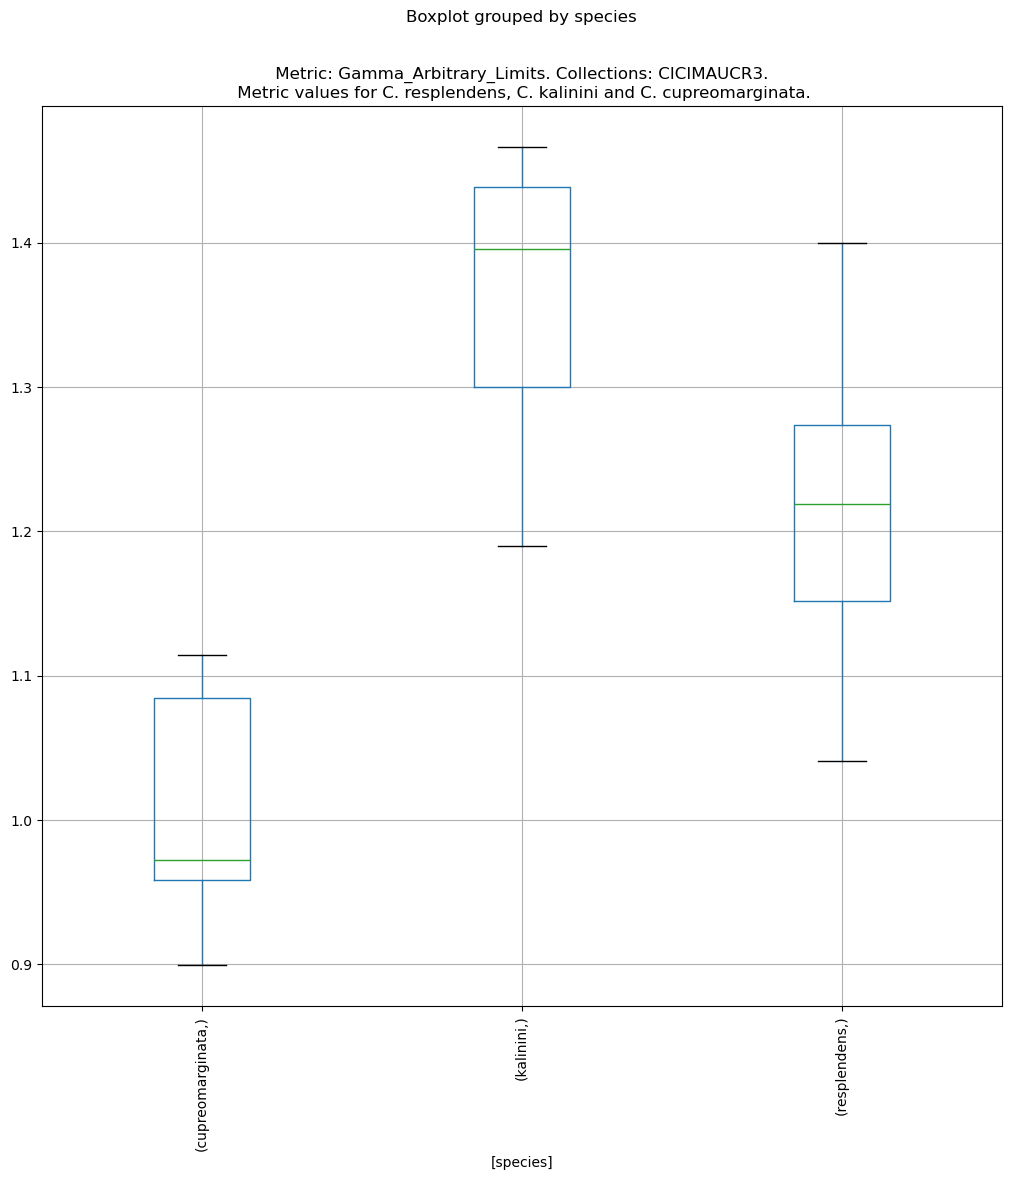

In [19]:
Metric_Testbench(Gamma_Arbitrary_Limits, all_spectra)

Directory 'C:\Users\EstebanSoto\Jupyter\escarabajos\reports\data_analysis\report_images\gamma_image' already exists.


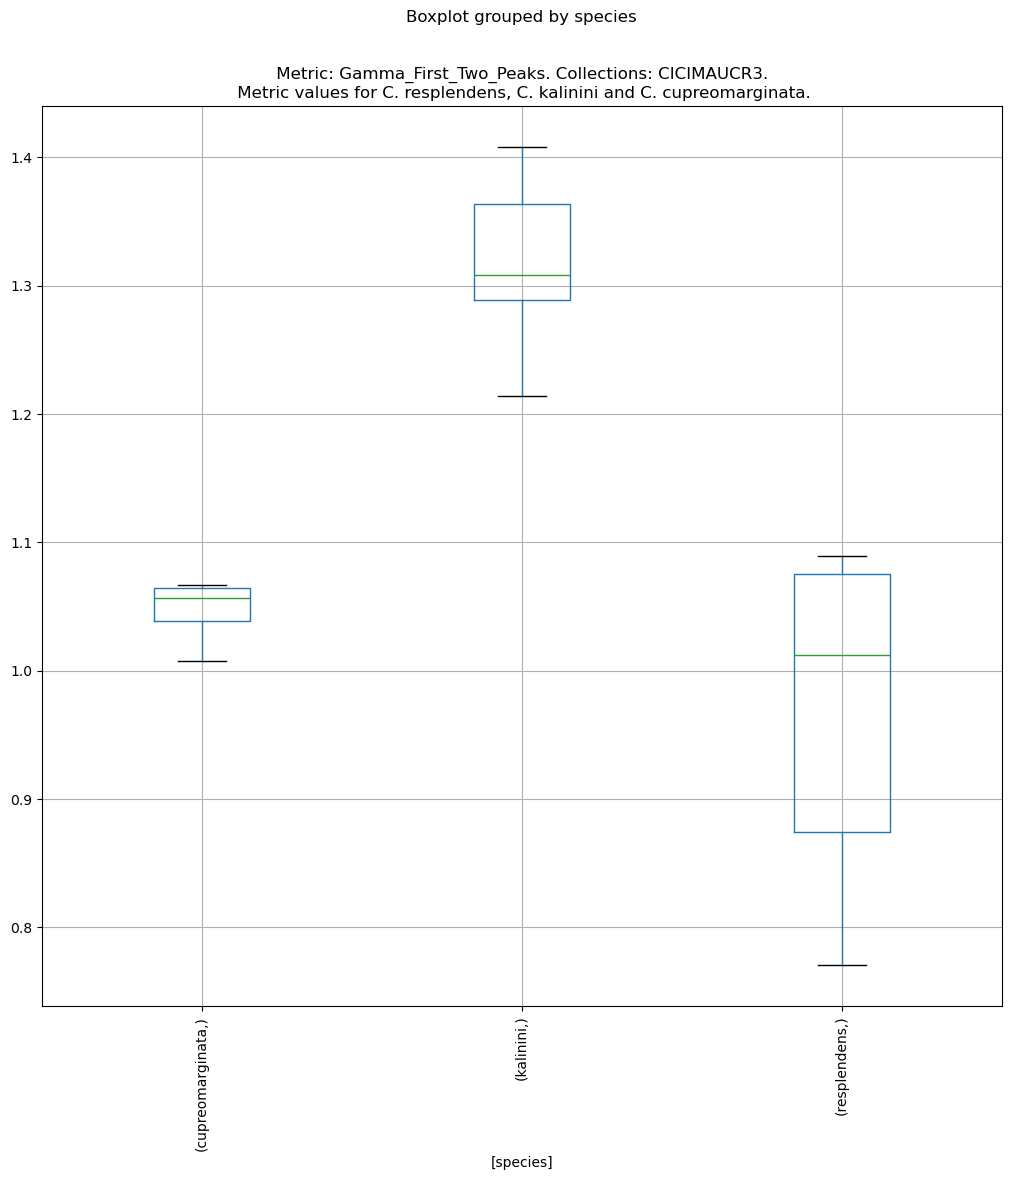

In [20]:
Metric_Testbench(Gamma_First_Two_Peaks, all_spectra)

Directory 'C:\Users\EstebanSoto\Jupyter\escarabajos\reports\data_analysis\report_images\gamma_image' already exists.


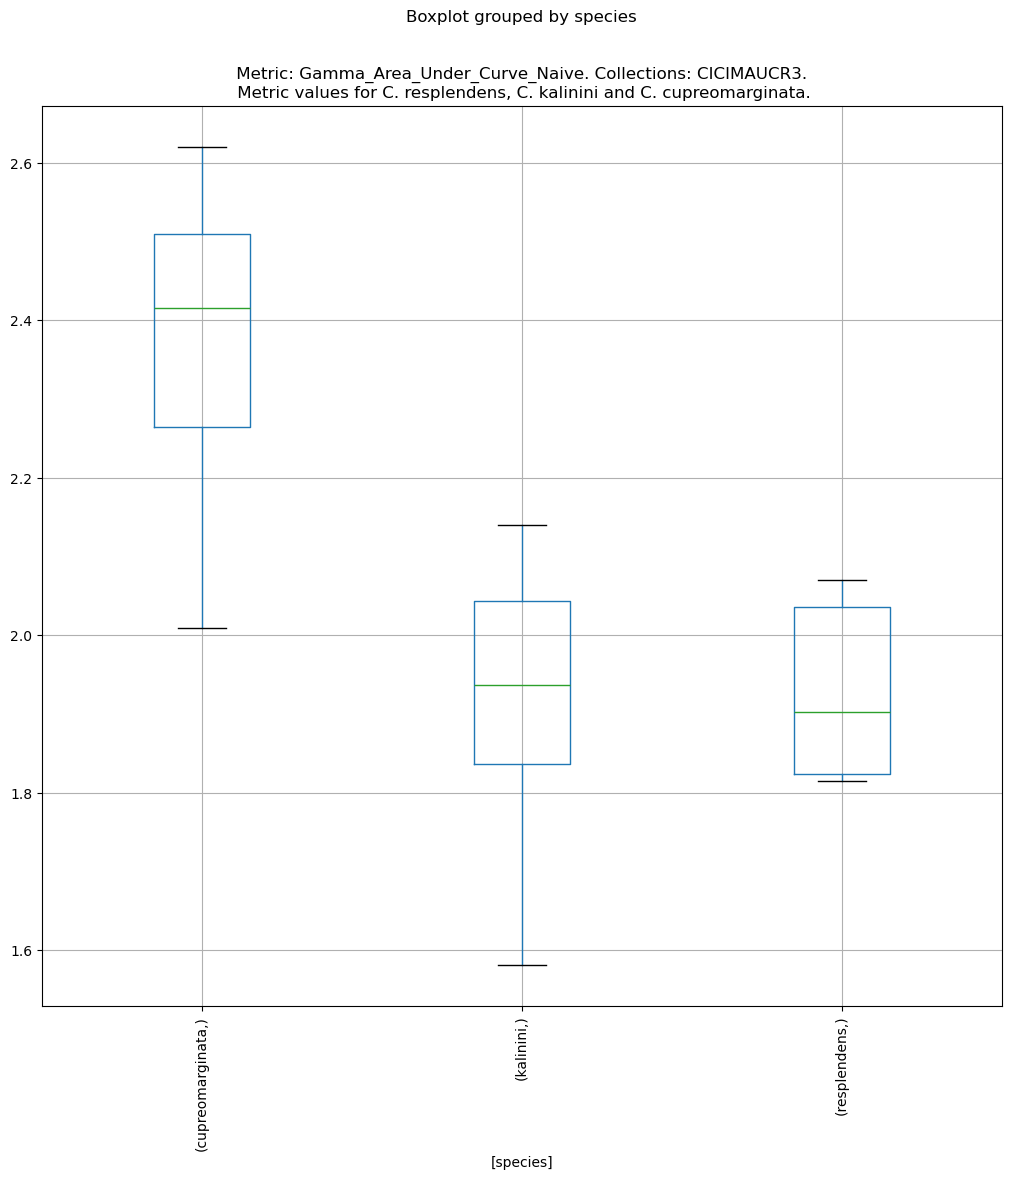

In [21]:
Metric_Testbench(Gamma_Area_Under_Curve_Naive, all_spectra)

Directory 'C:\Users\EstebanSoto\Jupyter\escarabajos\reports\data_analysis\report_images\gamma_image' already exists.


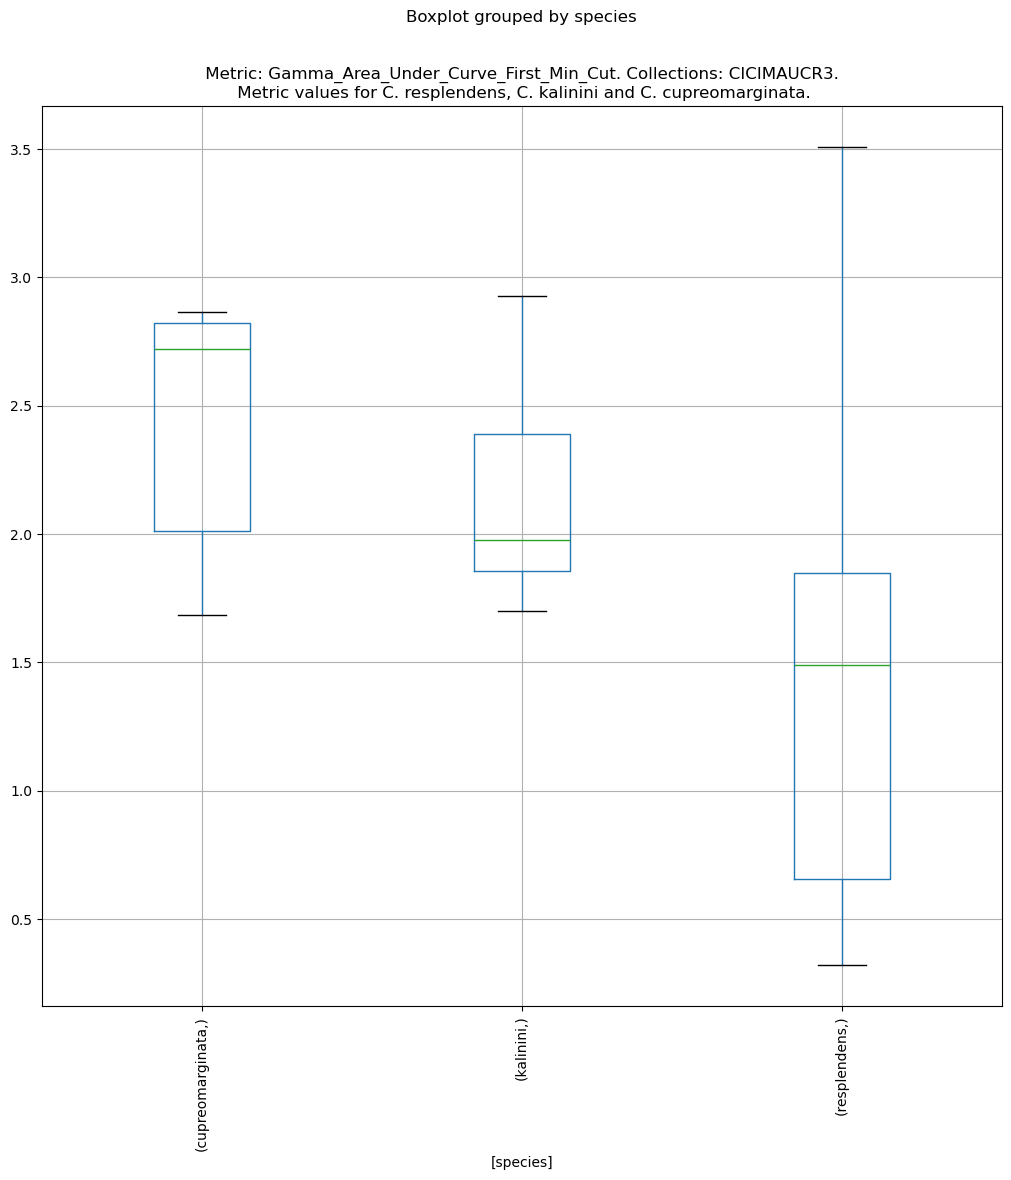

In [22]:
Metric_Testbench(Gamma_Area_Under_Curve_First_Min_Cut, all_spectra)

## Classification

In [23]:
def transpose_list(lst):
    return list(zip(*lst))

In [24]:
def get_nth_feature(data, n):
    feature_vector = [data[0], [x[n] for x in data[1]] , data[2]] 
    return feature_vector
def scatter_plot_2_variables(df_1, df_2):

    joint_df = pd.merge(df_1, df_2, on=["code", "species"], how="inner")
    column_list = joint_df.columns.tolist()
    print(column_list)
    column_list = [x for x in column_list if x not in ["code", "species"] ]
    print(column_list)
    plt.figure()
    sns.scatterplot(joint_df, x=column_list[0], y =column_list[1], hue="species")
    plt.show()


In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Sample data
np.random.seed(0)
n = 100


def scatter_plot_3_variables(df_1, df_2, df_3):
    
    joint_df = pd.merge(df_1, df_2, on=["code", "species"], how="inner")
    joint_df = pd.merge(joint_df, df_3, on=["code", "species"], how="inner")
    
    column_list = joint_df.columns.tolist()
    #print(column_list)
    column_list = [x for x in column_list if x not in ["code", "species"] ]
    #print(column_list)
    
    x = joint_df[column_list[0]]
    y = joint_df[column_list[1]]
    z = joint_df[column_list[2]]
    species = joint_df["species"]
    
    # Create color map
    colors = {'kalinini': 'r', 'resplendens': 'g', 'cupreomarginata': 'b'}
    
    # Create figure and 3D axis
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points with color based on the fourth dimension
    for category in set(species):
        indices = species == category
        ax.scatter(x[indices], y[indices], z[indices], c=colors[category], label=category, marker='o')
    
    # Set labels and title
    ax.set_xlabel(f'{column_list[0]}')
    ax.set_ylabel(f'{column_list[1]}')
    ax.set_zlabel(f'{column_list[2]}')
    #ax.set_title('3D Scatter plot with species based on Fourth Dimension')
    
    # Add legend
    ax.legend()
    
    plt.show()

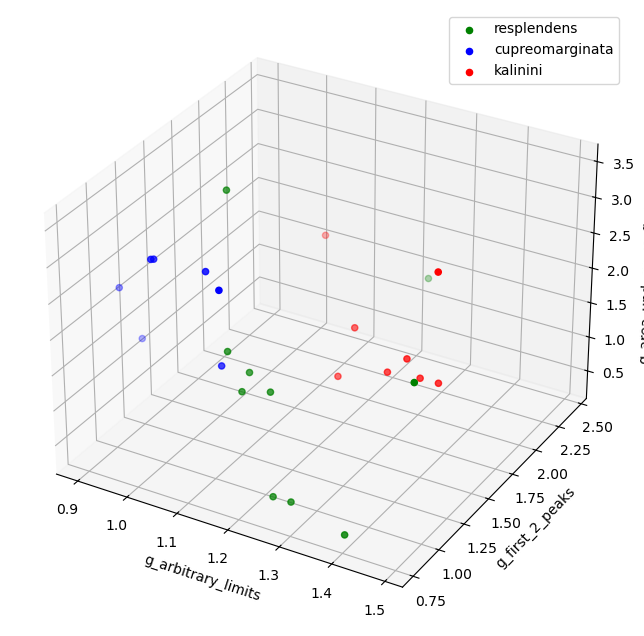

['code', 'g_first_2_peaks', 'species', '0_peak_wav_vec']
['g_first_2_peaks', '0_peak_wav_vec']


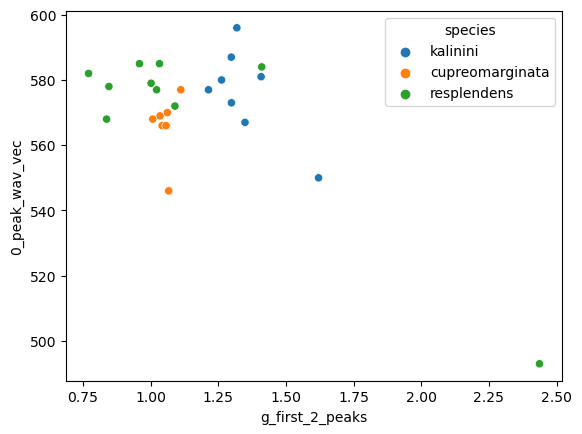

['code', 'g_first_2_peaks', 'species', '1_peak_wav_vec']
['g_first_2_peaks', '1_peak_wav_vec']


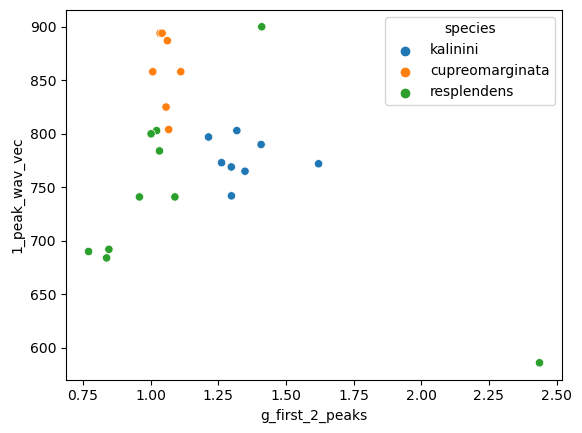

['code', 'g_first_2_peaks', 'species', '2_peak_wav_vec']
['g_first_2_peaks', '2_peak_wav_vec']


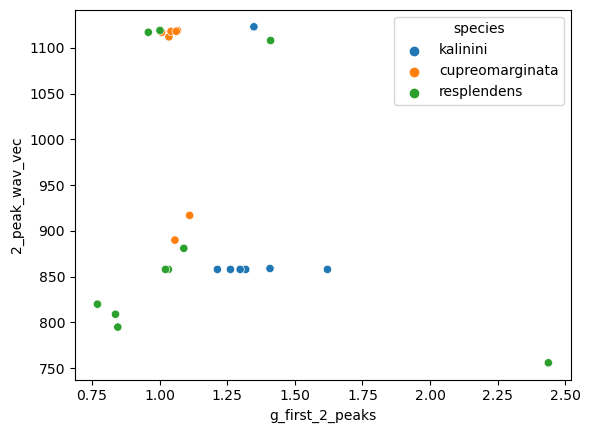

['code', 'g_first_2_peaks', 'species', '3_peak_wav_vec']
['g_first_2_peaks', '3_peak_wav_vec']


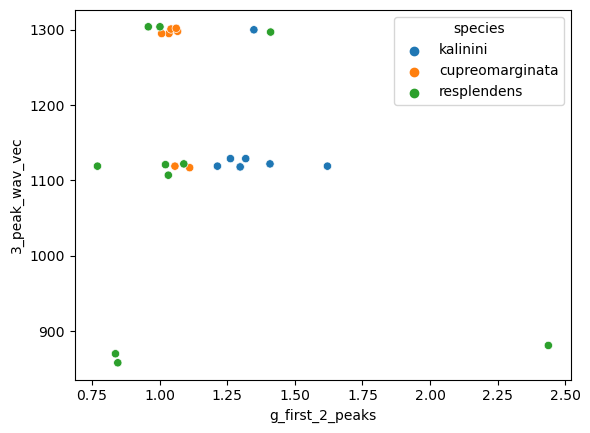

['code', 'g_first_2_peaks', 'species', '4_peak_wav_vec']
['g_first_2_peaks', '4_peak_wav_vec']


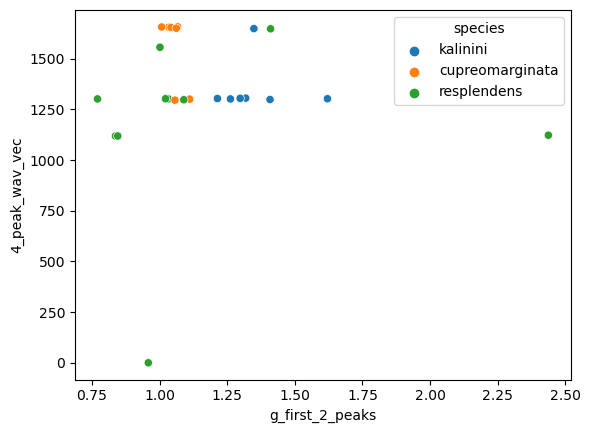

['code', 'g_first_2_peaks', 'species', '5_peak_wav_vec']
['g_first_2_peaks', '5_peak_wav_vec']


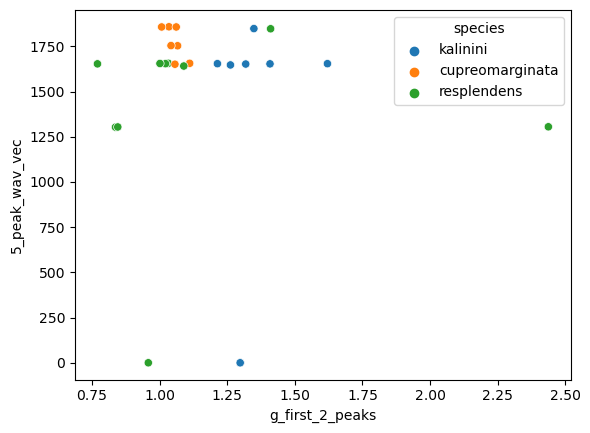

['code', 'g_first_2_peaks', 'species', '6_peak_wav_vec']
['g_first_2_peaks', '6_peak_wav_vec']


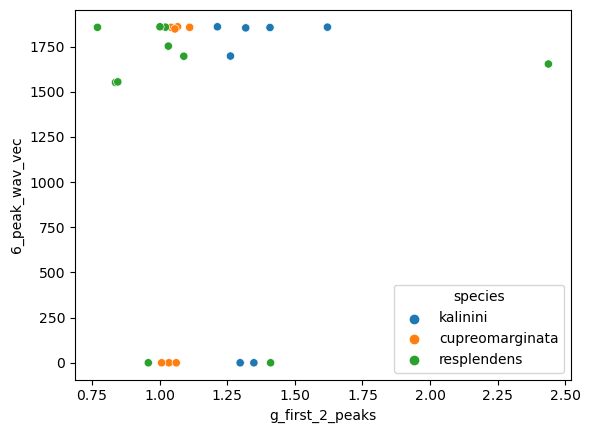

['code', 'g_first_2_peaks', 'species', '7_peak_wav_vec']
['g_first_2_peaks', '7_peak_wav_vec']


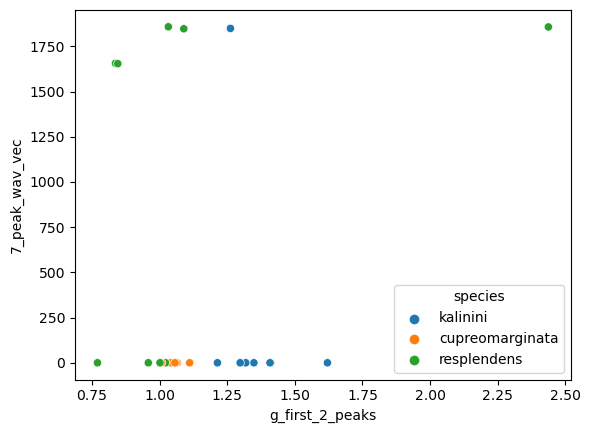

['code', 'g_first_2_peaks', 'species', '8_peak_wav_vec']
['g_first_2_peaks', '8_peak_wav_vec']


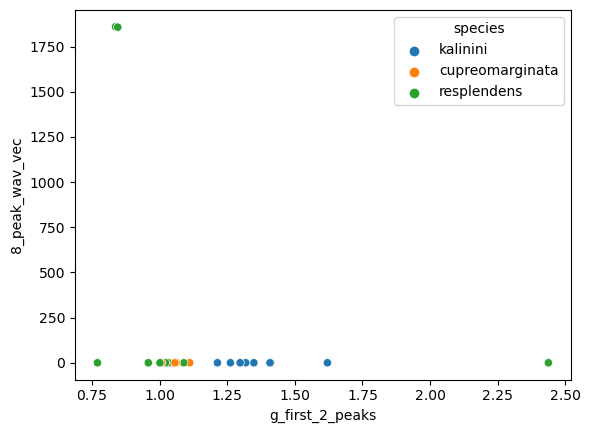

In [26]:
import seaborn as sns

#Definicion de las variables
gal_df = pd.DataFrame(transpose_list(gamma_arbitrary_limits_data), columns =["code", "g_arbitrary_limits", "species"]) 
gftp_df = pd.DataFrame(transpose_list(gamma_first_two_peaks_data), columns =["code", "g_first_2_peaks", "species"])
gaucfmc_df = pd.DataFrame(transpose_list(gamma_area_under_curve_first_min_cut_data), columns =["code", "g_area_und_curve_first_min", "species"]) 
gauc_df = pd.DataFrame(transpose_list(gamma_area_under_curve_data), columns =["code", "g_area_und_curve", "species"])

scatter_plot_3_variables(gal_df, gftp_df, gaucfmc_df)

for n in range(0,9):
    n_peak_wavelength_vector_data = get_nth_feature(data, n)
    pnwvd_df = pd.DataFrame(transpose_list(n_peak_wavelength_vector_data), columns =["code", f"{n}_peak_wav_vec", "species"])
    scatter_plot_2_variables(gftp_df, pnwvd_df)

    
#scatter_plot_2_variables(gal_df, gauc_df)
#scatter_plot_2_variables(gal_df, gaucfmc_df)
#scatter_plot_2_variables(gftp_df, gauc_df)
#scatter_plot_2_variables(gftp_df, gaucfmc_df)
#scatter_plot_2_variables(gftp_df, p1wvd_df)
#scatter_plot_2_variables(gftp_df, p2wvd_df)
#create scatter plot
#gamma_area_under_curve_data

## Prediction one variable

In [27]:
import sys

print(sys.version_info)

sys.version_info(major=3, minor=9, micro=18, releaselevel='final', serial=0)


In [28]:
#@title Import relevant modules

from tensorflow.keras import layers


# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

In [29]:
def replace_strings(lst):
    mapping = {"kalinini": 0, "resplendens": 1, "cupreomarginata": 2}
    return [mapping.get(item, item) for item in lst]

In [30]:
#gal_df 
#gftp_df 
#gaucfmc_df 
#gauc_df

def get_x_y(df):
    columns = df.columns
    x_column_name = [x for x in columns if x not in ["code", "species"]]
    x = df[x_column_name].values
    y = df["species"].values
    y_p = np.array(replace_strings(y))
    x = np.array(x)
    return x, y_p
    
x,y_p = get_x_y(gaucfmc_df)

y_p

array([0, 0, 0, 0, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 0, 0, 0, 2])

In [ ]:
import random

def permute_lists(list1, list2):
    # Generate a random permutation index
    permutation_index = list(range(len(list1)))
    random.shuffle(permutation_index)

    # Apply the same permutation to both lists
    permuted_list1 = [list1[i] for i in permutation_index]
    permuted_list2 = [list2[i] for i in permutation_index]

    return permuted_list1, permuted_list2
    
def partition_lists(list1, list2, fraction):
    if fraction >= 1:
        raise ValueError("Fraction must be less than 1")
    if fraction  < 0:
        raise ValueError("Fraction must be more than 0")
        
    num_elements = len(list1)
    num_selected = int(num_elements * fraction)

    # Partition elements based on the fraction
    selected_list1 = list1[:num_selected]
    selected_list2 = list2[:num_selected]
    remaining_list1 = list1[num_selected:]
    remaining_list2 = list2[num_selected:]

    return selected_list1, selected_list2, remaining_list1, remaining_list2

def get_training_and_test_data(features, labels, fraction):
    permutated_features, permuted_labels = permute_lists(features, labels)
    training_features, training_labels, test_features, test_labels = partition_lists(permutated_features, permuted_labels, fraction)
    training_features, training_labels, test_features, test_labels = np.array(training_features),  np.array(training_labels),  np.array(test_features),  np.array(test_labels)
    return training_features, training_labels, test_features, test_labels

x_train, y_train,x_test, y_test  = get_training_and_test_data(x, y_p, 0.5)

In [ ]:
print(x_train, y_train)

In [ ]:

def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

In [ ]:
def create_model(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(1,)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)
                      #validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.008
epochs = 150
batch_size = 3
validation_split = 0.3

# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
#epochs, hist = train_model(my_model, x_train, y_train, 
                           #epochs, batch_size, validation_split)
epochs, hist = train_model(my_model, x_train, y_train, 
                           epochs, batch_size)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test, y=y_test, batch_size=batch_size)

With hiperparameters: 
learning_rate = 0.008
epochs = 150
batch_size = 3
validation_split = 0.3

accuracy:
gal_df_:     0.43
gftp_df:     0.61 
gaucfmc_df:  0.77
gauc_df:     0.27

## Prediction vectorial features

In [ ]:
import numpy as np
gamma_vector_relative_reflectance_data_np = np.array(gamma_vector_relative_reflectance_data[1])
gamma_vector_relative_reflectance_data_np

In [ ]:
#gvrrd_df = pd.DataFrame(transpose_list(gamma_vector_relative_reflectance_data), columns =["code", "g_arbitrary_limits", "species"])
gvrrd_df = pd.DataFrame(transpose_list(gamma_vector_relative_reflectance_data), columns =["code", "g_arbitrary_limits", "species"])
gvrrd_df


In [ ]:
def get_x_y(df):
    columns = df.columns
    x_column_name = [x for x in columns if x not in ["code", "species"]]
    x = df[x_column_name].values
    x2 = []
    for element in x:
        xp = str(element).replace("[list(", "").replace(")]", "")
        ev = eval(xp)
        x2.append(ev)
    x2 = np.array(x2)
    
    y = df["species"].values
    y= replace_strings(y)
    y= np.array(y)
    #print(y)
    #print(df.dtypes)
    return x2, y

x,y_p = get_x_y(gvrrd_df)


In [ ]:
x_train, y_train,x_test, y_test  = get_training_and_test_data(x, y_p, 0.4)

In [ ]:
x_train[0]


In [ ]:
def create_model_2(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(9,)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=40, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  #model.add(tf.keras.layers.Dense(units=20, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.4))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True,
                      validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 150
batch_size = 1
validation_split = 0.0

# Establish the model's topography.
my_model = create_model_2(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, x_train, y_train, 
                           #epochs, batch_size, validation_split)
#epochs, hist = train_model(my_model, x_train, y_train, 
                           epochs, batch_size)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test, y=y_test, batch_size=batch_size)

#amplitud en IR vs amplitud en el visible
#700 nm
visible horizontal, IR vertical. 
#gamma vertical, amplitud pico IR horizontal 
#y es amplitud en el IR, x es el gamma

## Prediction 2 variables

In [ ]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

#first scenario gamma_first_two_peaks and gamma_area_under_curve_first_minimum
#Definicion de las variables
gal_df 
gftp_df 
gaucfmc_df 
gauc_df 


In [ ]:
#define the dataframe

complete_df = pd.merge(gal_df, gftp_df, on=["species","code"], how="inner")
complete_df = pd.merge(complete_df, gaucfmc_df, on=["species","code"], how="inner")
complete_df = pd.merge(complete_df, gauc_df, on=["species","code"], how="inner")
complete_df.drop(columns=['code'], inplace=True)

fraction = 0.8

def substitute_species(df):
    df.loc[df["species"] == "kalinini"] = -100.0
    df.loc[df["species"] == "resplendens"] = 0.0
    df.loc[df["species"] == "cupreomarginata"] = 100.0
    return df 

complete_df = substitute_species(complete_df)


def split_train_test(df, fraction):
    # Shuffle the DataFrame
    shuffled_df = df.sample(frac=1, random_state=0)
    
    # Calculate the number of rows for the training set
    train_size = int(fraction * len(df))
    
    # Split the DataFrame
    train_df = shuffled_df[:train_size]
    test_df = shuffled_df[train_size:]
    
    return train_df, test_df
    
train_df, test_df =split_train_test(complete_df, fraction)
#print(complete_df)
#print(train_df)
#print(test_df)

In [ ]:
# Keras Input tensors of float values.
inputs = {
    'g_arbitrary_limits':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='g_arbitrary_limits '),
    'g_first_2_peaks':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='g_first_2_peaks'),
    'g_area_und_curve_first_min':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='g_area_und_curve_first_min'),
    'g_area_und_curve':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='g_area_und_curve')
}

# Create a Normalization layer to normalize the median_income data.
g_area_und_curve_first_min = tf.keras.layers.Normalization(
    name='normalization_g_area_und_curve_first_min',
    axis=None)
g_area_und_curve_first_min.adapt(train_df['g_area_und_curve_first_min'])
g_area_und_curve_first_min = g_area_und_curve_first_min(inputs.get('g_area_und_curve_first_min'))

# Create a Normalization layer to normalize the population data.
g_area_und_curve = tf.keras.layers.Normalization(
    name='normalization_g_area_und_curve',
    axis=None)
g_area_und_curve.adapt(train_df['g_area_und_curve_first_min'])
g_area_und_curve = g_area_und_curve(inputs.get('g_area_und_curve'))


# Create a Normalization layer to normalize the latitude data.
g_arbitrary_limits = tf.keras.layers.Normalization(
    name='normalization_g_arbitrary_limits',
    axis=None)
g_arbitrary_limits.adapt(train_df['g_arbitrary_limits'])
g_arbitrary_limits = g_arbitrary_limits(inputs.get('g_arbitrary_limits'))


# Create a Normalization layer to normalize the longitude data.
g_first_2_peaks = tf.keras.layers.Normalization(
    name='normalization_g_first_2_peaks',
    axis=None)
g_first_2_peaks.adapt(train_df['g_first_2_peaks'])
g_first_2_peaks = g_first_2_peaks(inputs.get('g_first_2_peaks'))

# Concatenate our inputs into a single tensor.
preprocessing_layers = tf.keras.layers.Concatenate()(
    [g_arbitrary_limits, g_first_2_peaks, g_area_und_curve, g_area_und_curve_first_min])

print("Preprocessing layers defined.")

In [ ]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  # mse_training is a pandas Series, so convert it to a list first.
  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

print("Defined the plot_the_loss_curve function.")

In [ ]:
from tensorflow import Tensor

In [ ]:
#@title Define functions to create and train a linear regression model
def create_model(my_inputs, my_outputs, my_learning_rate):
  """Create and compile a simple linear regression model."""
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.Adam(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.MeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  print(features)
 
  #Considering y variable holds numpy array
  train_features_tensor = tf.convert_to_tensor(np.array(features.pop(label_name)), dtype=tf.int64) 
  label = train_median_house_value_normalized(train_features_tensor)

  for element in features:
      features[element] =  tf.convert_to_tensor(np.array(features[element]), dtype=tf.int64) 
      
  print(f"{label=}")
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse, history.history

print("Defined the create_model and train_model functions.")

In [ ]:
train_df.fillna(value='', inplace=True)
test_df.fillna(value='', inplace=True)

x_train = np.asarray(train_df['species']).astype('float32')
x_test = np.asarray(test_df['species']).astype('float32')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#@title Define normalized label columns
# Create Normalization layers to normalize the median_house_value data.
# Because median_house_value is our label (i.e., the target value we're
# predicting), these layers won't be added to our model.
train_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
train_median_house_value_normalized.adapt(x_train)
print(train_median_house_value_normalized)

test_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
test_median_house_value_normalized.adapt(x_test)
print(test_median_house_value_normalized)

In [ ]:
#@title Define linear regression model outputs
def get_outputs_linear_regression():
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }
  return outputs

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "species"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

outputs = get_outputs_linear_regression()

# Establish the model's topography.
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the normalized training set.
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size,
                          label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

test_features = {name:np.array(value) for name, value in test_df.items()}

test_features_tensor = tf.convert_to_tensor(np.array(test_features.pop(label_name)), dtype=tf.int64) 

test_label = test_median_house_value_normalized(test_features_tensor) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

In [ ]:
def get_outputs_dnn():
  # Create a Dense layer with 20 nodes.
  dense_output = tf.keras.layers.Dense(units=20,
                              activation='relu',
                              name='hidden_dense_layer_1')(preprocessing_layers)
  # Create a Dense layer with 12 nodes.
  dense_output = tf.keras.layers.Dense(units=12,
                              activation='relu',
                              name='hidden_dense_layer_2')(dense_output)
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(dense_output)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }

  return outputs

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "species"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model's topography.
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined in our inputs.
epochs, mse, history = train_model(my_model, train_df, epochs,
                                   batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}

train_features_tensor = tf.convert_to_tensor(np.array(test_features.pop(label_name)), dtype=tf.int64) 

test_label = test_median_house_value_normalized(train_features_tensor) # isolate the label

print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

In [ ]:
#Save model 

# Define the file path where you want to save your model
model_file_path = 'trained_model.h5'

# Save the model
my_model.save(model_file_path)

print("Model saved successfully at:", model_file_path)

In [ ]:
# Load the saved model
model_file_path = 'trained_model.h5'
loaded_model = tf.keras.models.load_model(model_file_path)

#load prediction data
#prediction_spectra

prediction_gamma_arbitrary_limits_data = feature_and_label_extractor(Gamma_Arbitrary_Limits, prediction_spectra)
prediction_gamma_first_two_peaks_data = feature_and_label_extractor(Gamma_First_Two_Peaks, prediction_spectra)
prediction_gamma_area_under_curve_data = feature_and_label_extractor(Gamma_Area_Under_Curve_Naive, prediction_spectra)
prediction_gamma_area_under_curve_first_min_cut_data = feature_and_label_extractor(Gamma_Area_Under_Curve_First_Min_Cut, prediction_spectra)

prediction_gamma_vector_relative_reflectance_data = feature_and_label_extractor(Gamma_Vector_Relative_Reflectance, prediction_spectra)
prediction_critical_points_data = feature_and_label_extractor(Critical_Points, prediction_spectra)

#Definicion de las variables
pred_gal_df = pd.DataFrame(transpose_list(prediction_gamma_arbitrary_limits_data), columns =["code", "g_arbitrary_limits", "real_species"]) 
pred_gftp_df = pd.DataFrame(transpose_list(prediction_gamma_first_two_peaks_data), columns =["code", "g_first_2_peaks", "real_species"])
pred_gaucfmc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_first_min_cut_data), columns =["code", "g_area_und_curve_first_min", "real_species"]) 
pred_gauc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_data), columns =["code", "g_area_und_curve", "real_species"])


#drop species

drop_pred_gal_df = pred_gal_df.copy()

drop_pred_gal_df.drop(columns=[ "real_species"], inplace=True)


drop_pred_gftp_df = pred_gftp_df.copy()
drop_pred_gftp_df.drop(columns=[ "real_species"], inplace=True)


drop_pred_gauc_df= pred_gauc_df.copy()
drop_pred_gauc_df.drop(columns=[ "real_species"], inplace=True)

drop_pred_gaucfmc_df=pred_gaucfmc_df.copy()
drop_pred_gaucfmc_df.drop(columns=[ "real_species"], inplace=True)


#merge on code
pred_complete_df = pd.merge(drop_pred_gal_df, drop_pred_gftp_df, on=["code"], how="inner")
print(pred_complete_df)
pred_complete_df = pd.merge(pred_complete_df, drop_pred_gauc_df, on=["code"], how="inner")
pred_complete_df = pd.merge(pred_complete_df, drop_pred_gaucfmc_df, on=["code"], how="inner")

pred_complete_df.drop(columns=[ "code"], inplace=True)
pred_complete_df


In [ ]:

# Assuming `features_to_predict` contains the features you want to use for prediction
prediction_features = {name:np.array(value) for name, value in pred_complete_df.items()}

#convert prediction_features to tensor
for element in prediction_features:
    prediction_features[element] = tf.convert_to_tensor(np.array(prediction_features[element]), dtype=tf.int64) 


# Predict using the loaded model
predictions = loaded_model.predict(prediction_features)

# Print the predictions
print(predictions)

In [ ]:
# Calculate the mean and standard deviation used for normalization
original_mean = train_df[label_name].mean()
original_stddev = train_df[label_name].std()
print(predictions['dense_output'])
predictions_unnormalized = (predictions['dense_output'] * original_stddev) + original_mean
predictions_unnormalized = predictions_unnormalized
print(predictions_unnormalized)

In [ ]:

def replace_back_strings(lst):
    lst = [int(x) for x in lst]
    mapping = {"kalinini": 0, "resplendens": 1, "cupreomarginata": 2, "unk1":3, "unk2":4}
    reverse_mapping = {value: key for key, value in mapping.items()}
    return [reverse_mapping.get(item, item) for item in lst]
    
predictions_labels = replace_back_strings(predictions_unnormalized)

print(predictions_labels)
print((pred_gal_df))

## Prediction 4 variables vector

In [ ]:
import sys

print(sys.version_info)

In [ ]:
#@title Import relevant modules

from tensorflow.keras import layers

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

In [ ]:
def replace_strings_3(lst):
    mapping = {"kalinini": 0, "resplendens": 1, "cupreomarginata": 2}
    return [mapping.get(item, item) for item in lst]

In [ ]:

complete_df = pd.merge(gal_df, gftp_df, on=["species","code"], how="inner")
complete_df = pd.merge(complete_df, gauc_df, on=["species","code"], how="inner")
complete_df = pd.merge(complete_df, gaucfmc_df, on=["species","code"], how="inner")
complete_df.drop(columns=['code'], inplace=True)

def replace_species_with_categorical(df):
    
    df.loc[df["species"]=="kalinini","species"] = 0
    df.loc[df["species"]=="resplendens", "species"] = 1
    df.loc[df["species"]=="cupreomarginata", "species"] = 2

    df.loc[df["species"]=="kalinini", "species"] = 0
    df.loc[df["species"]=="resplendens", "species"] = 1
    df.loc[df["species"]=="cupreomarginata", "species"] = 2

    df.loc[df["species"]=="kalinini", "species"] = 0
    df.loc[df["species"]=="resplendens", "species"] = 1
    df.loc[df["species"]=="cupreomarginata", "species"] = 1
    return df

complete_df = replace_species_with_categorical(complete_df)
#complete_df.drop(columns=['species'], inplace=True)
complete_df

In [ ]:

shuffled_df = complete_df.sample(frac=1, random_state=42)  # Random_state for reproducibility

# Define the fraction of data to be used for training
train_fraction = 0.66  # For example, 80% for training, 20% for testing

# Calculate the number of rows for the training set
train_size = int(train_fraction * len(complete_df))

# Split the shuffled DataFrame into train and test sets
train_data = shuffled_df.iloc[:train_size]
test_data = shuffled_df.iloc[train_size:]

# Split the shuffled DataFrame into features and labels
train_data_features = train_data.drop(columns=['species'], inplace=False)
train_data_labels =  train_data.drop(columns=['g_arbitrary_limits','g_first_2_peaks','g_area_und_curve_first_min','g_area_und_curve'], inplace=False)
test_data_features =  test_data.drop(columns=['species'], inplace=False)
test_data_labels =  test_data.drop(columns=['g_arbitrary_limits','g_first_2_peaks','g_area_und_curve_first_min','g_area_und_curve'], inplace=False)

from tensorflow.keras.utils import to_categorical

# Assuming y_train and y_test are your integer labels
train_data_labels_one_hot = to_categorical(train_data_labels, num_classes=3)
test_data_labels_one_hot = to_categorical(test_data_labels, num_classes=3)


print(train_data_features)
print(len(train_data))
print(len(test_data))
#print(test_features)
#print(test_labels)

In [ ]:
# Select 2
train_data_features = train_data_features.drop(columns=['g_arbitrary_limits',"g_area_und_curve"], inplace=False)
test_data_features =  test_data_features.drop(columns=['g_arbitrary_limits',"g_area_und_curve"], inplace=False)

print(train_data_features)
print(test_data_features)

In [ ]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

In [ ]:
def create_model_3(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(2,)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),loss="sparse_categorical_crossentropy", metrics=['accuracy'])
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)
                      #validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.008
epochs = 150
batch_size = 3
validation_split = 0.2

# Establish the model's topography.
my_model = create_model_3(learning_rate)

# Train the model on the normalized training set.
#epochs, hist = train_model(my_model, x_train, y_train, 
                           #epochs, batch_size, validation_split)
epochs, hist = train_model(my_model, train_data_features, train_data_labels_one_hot, 
                           epochs, batch_size)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=test_data_features, y=test_data_labels_one_hot, batch_size=batch_size)


In [ ]:
#Save model 

# Define the file path where you want to save your model
model_file_path = 'trained_model_4_var.h5'

# Save the model
my_model.save(model_file_path)

print("Model saved successfully at:", model_file_path)

In [ ]:
# Load the saved model
model_file_path = 'trained_model_4_var.h5'
loaded_model2 = tf.keras.models.load_model(model_file_path)

#load prediction data
#prediction_spectra

prediction_gamma_arbitrary_limits_data = feature_and_label_extractor(Gamma_Arbitrary_Limits, prediction_spectra)
prediction_gamma_first_two_peaks_data = feature_and_label_extractor(Gamma_First_Two_Peaks, prediction_spectra)
prediction_gamma_area_under_curve_data = feature_and_label_extractor(Gamma_Area_Under_Curve_Naive, prediction_spectra)
prediction_gamma_area_under_curve_first_min_cut_data = feature_and_label_extractor(Gamma_Area_Under_Curve_First_Min_Cut, prediction_spectra)

#prediction_gamma_vector_relative_reflectance_data = feature_and_label_extractor(Gamma_Vector_Relative_Reflectance, prediction_spectra)
#prediction_critical_points_data = feature_and_label_extractor(Critical_Points, prediction_spectra)

#Definicion de las variables
pred_gal_df = pd.DataFrame(transpose_list(prediction_gamma_arbitrary_limits_data), columns =["code", "g_arbitrary_limits", "real_species"]) 
pred_gftp_df = pd.DataFrame(transpose_list(prediction_gamma_first_two_peaks_data), columns =["code", "g_first_2_peaks", "real_species"])
pred_gauc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_data), columns =["code", "g_area_und_curve", "real_species"])
pred_gaucfmc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_first_min_cut_data), columns =["code", "g_area_und_curve_first_min", "real_species"]) 


#drop species

drop_pred_gal_df = pred_gal_df.copy()
drop_pred_gal_df.drop(columns=[ "real_species"], inplace=True)


drop_pred_gftp_df = pred_gftp_df.copy()
drop_pred_gftp_df.drop(columns=[ "real_species"], inplace=True)


drop_pred_gauc_df= pred_gauc_df.copy()
drop_pred_gauc_df.drop(columns=[ "real_species"], inplace=True)

drop_pred_gaucfmc_df=pred_gaucfmc_df.copy()
drop_pred_gaucfmc_df.drop(columns=[ "real_species"], inplace=True)


#merge on code
pred_complete_df = pd.merge(drop_pred_gal_df, drop_pred_gftp_df, on=["code"], how="inner")
#print(pred_complete_df)
pred_complete_df = pd.merge(pred_complete_df, drop_pred_gauc_df, on=["code"], how="inner")
pred_complete_df = pd.merge(pred_complete_df, drop_pred_gaucfmc_df, on=["code"], how="inner")

no_code_pred_complete_df= pred_complete_df.copy()
no_code_pred_complete_df.drop(columns=[ "code"], inplace=True)
pred_complete_df

In [ ]:
# Select 2
no_code_pred_complete_df = no_code_pred_complete_df.drop(columns=['g_arbitrary_limits',"g_area_und_curve"], inplace=False)

print(no_code_pred_complete_df)


In [ ]:
# Assuming `features_to_predict` contains the features you want to use for prediction
prediction_features = pd.DataFrame({name:np.array(value) for name, value in no_code_pred_complete_df.items()})

#print(prediction_features)
#print(pred_complete_df)
#convert prediction_features to tensor
for element in prediction_features:
    prediction_features[element] = tf.convert_to_tensor(np.array(prediction_features[element]), dtype=tf.int64) 


# Predict using the loaded model
predictions = loaded_model2.predict(prediction_features)

# Print the predictions
#print(predictions)
prediction_df = pd.DataFrame(predictions, columns=["kalinini", "resplendens", "cupreomarginata"])
prediction_df

In [ ]:
#pred_gal_df = pd.DataFrame(transpose_list(prediction_gamma_arbitrary_limits_data), columns =["code", "g_arbitrary_limits", "real_species"]) 
#pred_gftp_df = pd.DataFrame(transpose_list(prediction_gamma_first_two_peaks_data), columns =["code", "g_first_2_peaks", "real_species"])
#pred_gaucfmc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_first_min_cut_data), columns =["code", "g_area_und_curve_first_min", "real_species"]) 
#pred_gauc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_data), columns =["code", "g_area_und_curve", "real_species"])

merged_prediction_data = pd.merge(pred_gal_df, pred_gftp_df , on=["code","real_species"], how="inner")
merged_prediction_data = pd.merge(merged_prediction_data, pred_gauc_df , on=["code","real_species"], how="inner")
merged_prediction_data = pd.merge(merged_prediction_data, pred_gaucfmc_df , on=["code","real_species"], how="inner")
merged_prediction_data